# Predict house prices using advanced regression techniques
## Processing the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### Read the datasets

In [2]:
def read_data(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    print('Number of rows in the train data : ', train.shape[0])
    print('Number of columns : ', train.shape[1])
    print('Number of rows in the train data : ', test.shape[0])
    print('Number of columns : ', test.shape[1])

    return train, test

def split_categories(df):
    quantitative =df.select_dtypes(exclude=['object']).copy().columns
    quantitative = quantitative.drop('SalePrice')
    quantitative = quantitative.drop('Id')
    qualitative =df.select_dtypes(include=['object']).columns

    print("\nList of the quantitatives variables : \n", list(quantitative))
    print("\nList of the qualitatives variables : \n", list(qualitative))

    return quantitative, qualitative

train, test = read_data('../data/train.csv', '../data/test.csv')
quantitative, qualitative = split_categories(train)

train.head()

Number of rows in the train data :  1460
Number of columns :  81
Number of rows in the train data :  1459
Number of columns :  80

List of the quantitatives variables : 
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

List of the qualitatives variables : 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Handling missing values
First we need to know which of the features have missing values in our data.

The columns that have more than 50% of missing values :  {'Fence', 'PoolQC', 'MiscFeature', 'Alley'}
Number of columns having missing values :  19


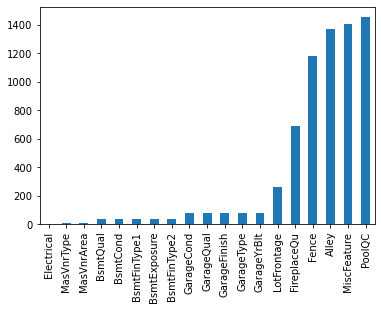

In [3]:
def plot_missing():
    print('Number of columns having missing values : ', len(set(train.columns[train.isnull().mean() > 0])))
    try:
        missing = train.isnull().sum()
        missing = missing[missing > 0]
        missing.sort_values(inplace=True)
        missing.plot.bar();
    except IndexError:
        None

print('The columns that have more than 50% of missing values : ', set(train.columns[train.isnull().mean() > .50]))
plot_missing()

We need to fill this numerical missing values by the mean according to the features.

Number of columns having missing values :  16


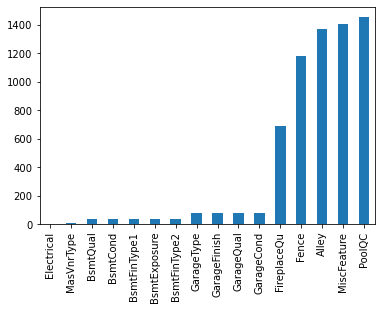

In [4]:
def fill_missing(num_vars):
    for col in num_vars:
        train[col].fillna((train[col].mean()), inplace=True)

fill_missing(quantitative)
plot_missing()

Dummy the categorical variables

In [5]:
def dummy_variables(df, cat_vars):
    for var in cat_vars:
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var])], axis=1)
    return df

train = dummy_variables(train, qualitative)
print('Number of total features : ', train.shape[1])

Number of total features :  290


## The outliers

Checking the outliers

,SalePrice
11,345000
53,385000
58,438780
112,383970
151,372402
...,...
1268,381000
1353,410000
1373,466500
1388,377500


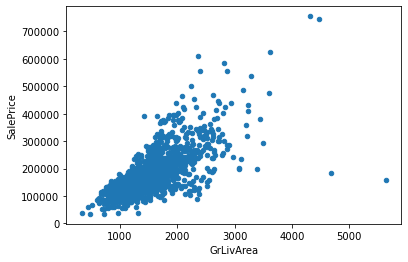

In [6]:
def outliers(df, cols, q1=0.25, q3=0.75):
    q1 = df[cols].quantile(q1)
    q3 = df[cols].quantile(q3)
    iqr = q3 - q1

    max_value = q3 + 1.5 * iqr
    min_value = q1 - 1.5 * iqr

    df_outliers = df[(df[cols] > max_value) | (df[cols] < min_value)]

    return df_outliers

def outliers_visualization(df, x_axis, y_axis):
    data = pd.concat([df[y_axis], df[x_axis]], axis=1)
    data.plot.scatter(x=x_axis, y=y_axis);

salePrice_outliers = outliers(train[['SalePrice']], 'SalePrice')
outliers_visualization(train, 'GrLivArea', 'SalePrice')
salePrice_outliers

## Normalization
Normalize all skewed numeric features for best fiting the model and minimizing the outliers.
### Which are skewed features ?

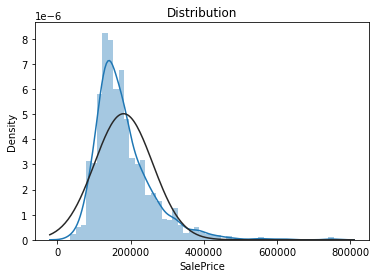

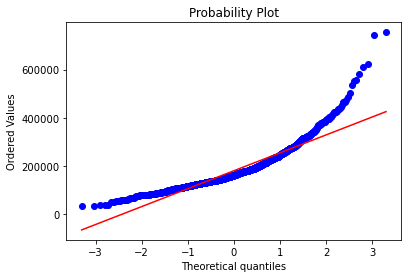

In [7]:
def plot_distribution_proba(target):
    plt.figure(1)
    plt.title('Distribution')
    sns.distplot(target, fit=stats.norm)
    plt.figure(2)
    stats.probplot(train['SalePrice'], plot=plt);

plot_distribution_proba(train['SalePrice'])

For better distribution, we need to perform a log transformation to all the skewed numerical features.

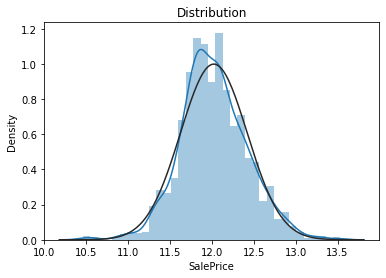

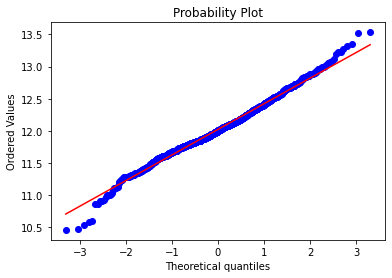

In [8]:
def log_norm():
    train['SalePrice'] = np.log1p(train['SalePrice'])
    skewed_feats = train[quantitative].apply(lambda x: stats.skew(x))
    skewed_feats = skewed_feats[skewed_feats > .75]
    train[skewed_feats.index] = np.log1p(train[skewed_feats.index])
    
log_norm()
plot_distribution_proba(train['SalePrice'])

## Regression model

In [12]:
def split_trainset(df):
    y = df['SalePrice']
    X = df.drop('SalePrice', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    print('Shape of X_train : ', X_train.shape)
    print('Shape of X_test : ', X_test.shape)

    return X_train, X_test, y_train, y_test

def train_model(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)

    return model

def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print('Mean squarred error : ', mse)

def train_test(df):
    X_train, X_test, y_train, y_test = split_trainset(df)
    model = train_model(X_train, y_train)
    test_model(model, X_test, y_test)

train_test(train)

Shape of X_train :  (1095, 289)
Shape of X_test :  (365, 289)
Mean squarred error :  0.01867768782296888
